#  Ataki Adwersarialne - Fast Gradient Sign Method (FGSM) na MNIST

W tym notatniku przeprowadzimy atak adwersarialny metodą **Fast Gradient Sign Method (FGSM)**, aby zademonstrować wrażliwość prostego modelu konwolucyjnego (CNN) na niemal niezauważalne perturbacje w danych wejściowych.

Celem ataku FGSM jest wygenerowanie tzw. **przykładu adwersarialnego**, czyli obrazu, który jest wizualnie identyczny z oryginalnym, ale jest błędnie klasyfikowany przez model.

**Kluczowe kroki:**
1.  Zbudowanie i wytrenowanie prostego modelu CNN na zbiorze MNIST.
2.  Implementacja funkcji do obliczania **podpisanego gradientu** (signed gradient), który jest podstawą ataku FGSM.
3.  Wygenerowanie obrazów adwersarialnych i ocena ich wpływu na predykcje modelu.

In [1]:
#Importy i Konfiguracja
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Ustawiamy seed dla powtarzalności wyników
np.random.seed(42)
tf.random.set_seed(42)

print(f"Wersja TensorFlow: {tf.__version__}")

Wersja TensorFlow: 2.20.0


In [2]:
#ładowanie danych i normalizacja
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizacja: skalowanie do zakresu [0, 1] i konwersja na float32
x_train = x_train.astype(np.float32) / 255.0
x_test  = x_test.astype(np.float32)  / 255.0

# CNN oczekuje wymiaru kanału (ostatni wymiar), więc dodajemy
x_train = x_train[..., np.newaxis]  # shape: (N, 28, 28, 1)
x_test  = x_test[..., np.newaxis]

# Konwersja etykiet na format one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, 10)
y_test_oh  = tf.keras.utils.to_categorical(y_test, 10)

print(f"Kształt danych testowych: {x_test.shape}")

Kształt danych testowych: (10000, 28, 28, 1)


In [3]:
#prosty model CNN
model = tf.keras.models.Sequential([
    # Konwolucja, Max Pooling
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Spłaszczenie do wektora
    tf.keras.layers.Flatten(),
    # Warstwy gęste (Dense)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') # Warstwa wyjściowa
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trening na 3 epokach (krótki trening dla demonstracji)
print("Rozpoczynanie treningu modelu...")
history = model.fit(x_train, y_train_oh, epochs=3, validation_split=0.1, batch_size=128, verbose=1)

# Ocena na zbiorze testowym
loss_test, acc_test = model.evaluate(x_test, y_test_oh, verbose=0)
print(f"\n Trening zakończony. Test loss: {loss_test:.4f}, Test Acc: {acc_test:.4f}")

Rozpoczynanie treningu modelu...
Epoch 1/3


c:\Users\Damian\Desktop\Inżynierka here\Adversarial_Attacks\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9369 - loss: 0.2245 - val_accuracy: 0.9790 - val_loss: 0.0789
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9790 - loss: 0.0707 - val_accuracy: 0.9850 - val_loss: 0.0552
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9859 - loss: 0.0466 - val_accuracy: 0.9852 - val_loss: 0.0522

 Trening zakończony. Test loss: 0.0492, Test Acc: 0.9836


#  Wyjaśnienie Fast Gradient Sign Method (FGSM)

Atak FGSM, zaproponowany przez Goodfellowa i in. w 2014 roku, jest **jednokrokowym** atakiem, który szybko generuje perturbacje. Działa on na zasadzie wykorzystania gradientu funkcji straty, aby wiedzieć, w którym kierunku należy zmienić piksele obrazu wejściowego, by maksymalnie zwiększyć stratę (a tym samym spowodować błędną klasyfikację).

**Matematycznie:**

Obraz adwersarialny $x_{adv}$ jest konstruowany następująco:
$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))$$

Gdzie:
* $x$ to **oryginalny obraz**.
* $\epsilon$ (epsilon) to **współczynnik perturbacji** (siła ataku), kontrolujący wizualną subtelność zmian.
* $J(\theta, x, y)$ to **funkcja straty** (np. `categorical_crossentropy`).
* $\nabla_x J$ to **gradient straty** względem obrazu $x$.
* $\text{sign}(\cdot)$ to **funkcja znaku**, która zwraca $+1$ lub $-1$, co oznacza, że perturbacja jest dodawana w kierunku, który maksymalizuje stratę.

**Wpływ $\epsilon$:**
* **Małe $\epsilon$ (np. 0.01 - 0.1):** Perturbacja jest subtelna, ale może być wystarczająca, aby zwieść model.
* **Duże $\epsilon$ (np. 0.3 - 0.5):** Perturbacja jest bardziej widoczna, co gwarantuje sukces ataku, ale może być łatwiejsze do wykrycia.

In [5]:
#FGSM: tworzymy perturbacje (funkcja pomocnicza)
@tf.function
def make_adversarial_pattern(obraz: tf.Tensor, etykieta: tf.Tensor) -> tf.Tensor:
    """
    Oblicza znak gradientu funkcji straty względem obrazu wejściowego (Signed Gradient).

    obraz: tensor shape (1,28,28,1)
    etykieta: one-hot shape (1,10)
    zwraca: signed gradient (wzorzec ataku, ten sam shape co obraz)
    """
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(obraz) # Musimy obserwować obraz, by obliczyć jego gradient
        preds = model(obraz)
        loss = loss_object(etykieta, preds)

    # Obliczenie gradientu straty względem obrazu
    grad = tape.gradient(loss, obraz)
    # Wyodrębnienie znaku (sign) z gradientu
    signed_grad = tf.sign(grad)
    return signed_grad

Generowanie i wyświetlanie przykładów adwersarialnych dla indeksów: [8, 12, 19, 25]

--- PRZYKŁAD DLA INDEKSU: 8 ---


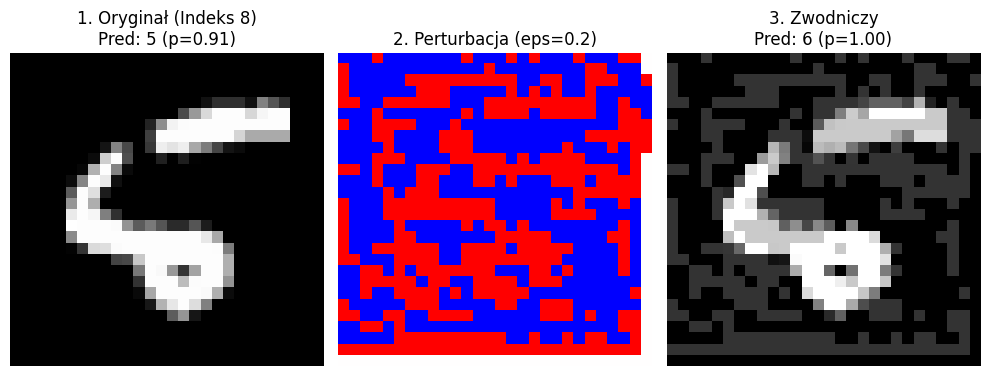

Oryginalna predykcja: 5 (Zgodna z prawdą: 5)
Zwodnicza predykcja:   6

--- PRZYKŁAD DLA INDEKSU: 12 ---


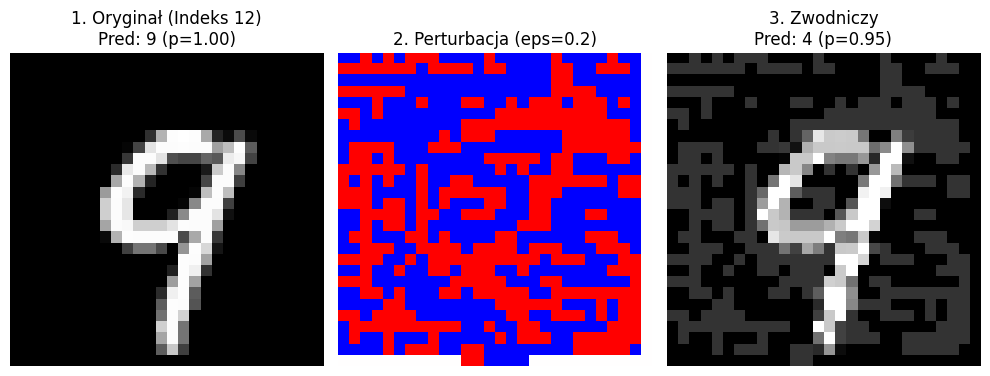

Oryginalna predykcja: 9 (Zgodna z prawdą: 9)
Zwodnicza predykcja:   4

--- PRZYKŁAD DLA INDEKSU: 19 ---


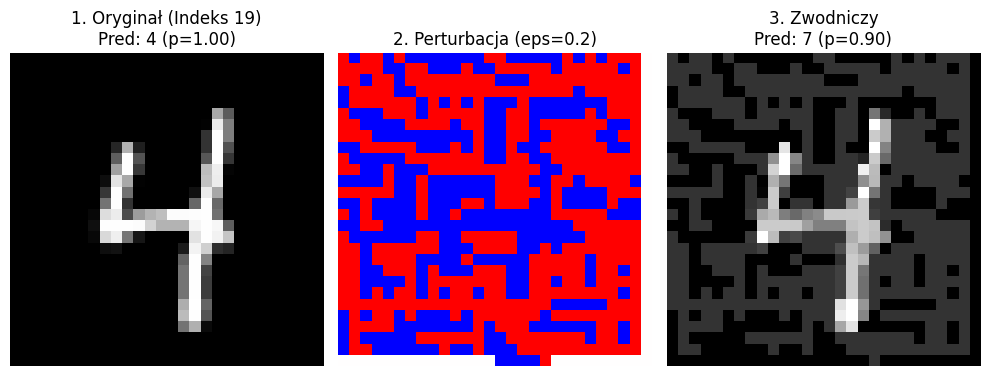

Oryginalna predykcja: 4 (Zgodna z prawdą: 4)
Zwodnicza predykcja:   7

--- PRZYKŁAD DLA INDEKSU: 25 ---


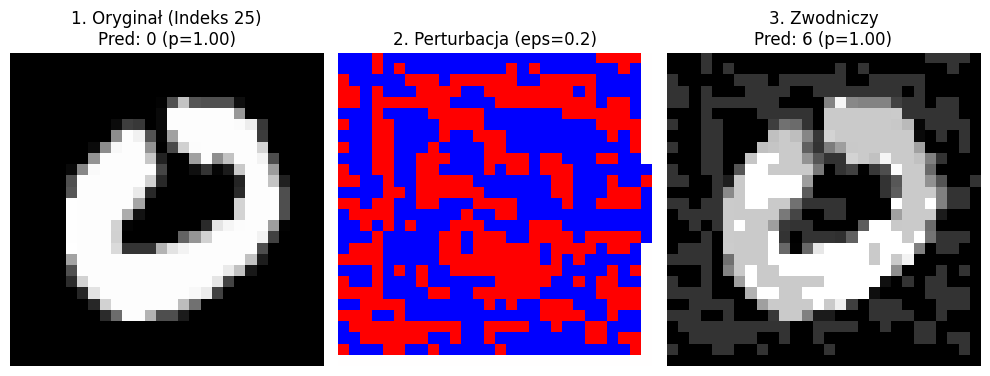

Oryginalna predykcja: 0 (Zgodna z prawdą: 0)
Zwodnicza predykcja:   6



In [6]:
# Lista indeksów do sprawdzenia
# Wybieramy cztery różne indeksy (np. 8, 12, 19, 25), aby zobaczyć różnorodność ataków.
selected_indices = [8, 12, 19, 25]
eps = 0.2  # Utrzymujemy siłę ataku

print(f"Generowanie i wyświetlanie przykładów adwersarialnych dla indeksów: {selected_indices}\n")

for idx in selected_indices:
    print(f"--- PRZYKŁAD DLA INDEKSU: {idx} ---")

    # 1. Wybór obrazu i etykiety
    obraz = x_test[idx]                # shape (28,28,1)
    etykieta = y_test_oh[idx]          # one-hot

    # Konwersja na batch
    obraz_b = tf.convert_to_tensor(obraz.reshape((1,28,28,1)), dtype=tf.float32)
    etykieta_b = tf.convert_to_tensor(etykieta.reshape((1,10)), dtype=tf.float32)

    # 2. Generowanie perturbacji i obrazu adwersarialnego
    signed_grad = make_adversarial_pattern(obraz_b, etykieta_b)
    obraz_adv = obraz_b + eps * signed_grad
    obraz_adv = tf.clip_by_value(obraz_adv, 0.0, 1.0) # Przycięcie wartości do [0,1]

    # 3. Predykcje modelu
    pred_org = model.predict(obraz_b, verbose=0)
    pred_adv = model.predict(obraz_adv, verbose=0)

    # 4. Wyświetlanie wyników

    # Funkcja do wyświetlania obrazów (modyfikacja, aby działała w pętli)
    def pokaz_przyklad(obraz_b, signed_grad, obraz_adv, pred_org, pred_adv, eps, idx):
        plt.figure(figsize=(10, 5))

        # Oryginalny obraz
        plt.subplot(1, 3, 1)
        plt.title(f"1. Oryginał (Indeks {idx})\nPred: {np.argmax(pred_org)} (p={np.max(pred_org):.2f})")
        plt.imshow(obraz_b[0,...,0], cmap='gray')
        plt.axis('off')

        # Perturbacja
        plt.subplot(1, 3, 2)
        plt.title(f"2. Perturbacja (eps={eps})")
        plt.imshow(signed_grad[0,...,0], cmap='bwr', vmin=-1, vmax=1)
        plt.axis('off')

        # Obraz adwersarialny
        plt.subplot(1, 3, 3)
        plt.title(f"3. Zwodniczy\nPred: {np.argmax(pred_adv)} (p={np.max(pred_adv):.2f})")
        plt.imshow(obraz_adv[0,...,0], cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    pokaz_przyklad(obraz_b, signed_grad, obraz_adv, pred_org, pred_adv, eps, idx)

    # 5. Podsumowanie predykcji
    print(f"Oryginalna predykcja: {np.argmax(pred_org)} (Zgodna z prawdą: {np.argmax(etykieta_b)})")
    print(f"Zwodnicza predykcja:   {np.argmax(pred_adv)}\n")

# Analiza wpływu Epsilon na skuteczność modelu (Accuracy vs Epsilon)

Poniżej przeprowadzimy eksperyment sprawdzający, jak zmienia się dokładność modelu w zależności od siły ataku (wartości epsilon). Przetestujemy wartości od 0 do 0.3.

Obliczanie gradientów dla całego zbioru testowego...

Tabela wyników (Accuracy vs Epsilon):


,Epsilon,Accuracy
0,0.00,0.9839
1,0.05,0.9108
2,0.10,0.6669
3,0.15,0.2780
4,0.20,0.0614
5,0.25,0.0098
6,0.30,0.0033


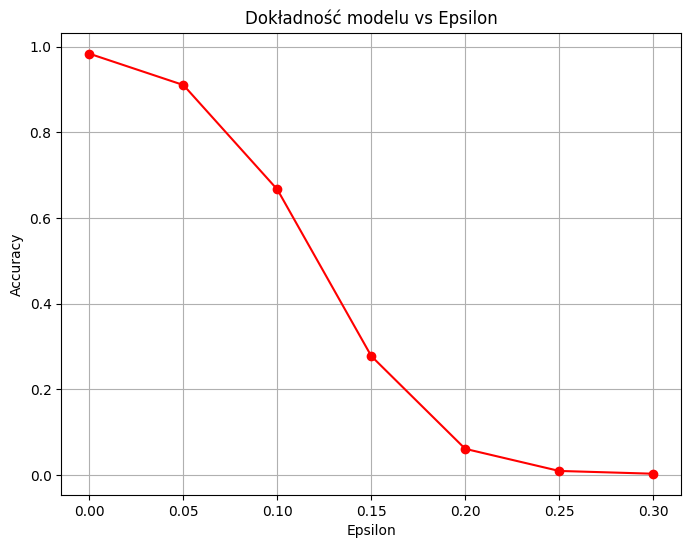

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def run_attack_evaluation(model, x_test, y_test_oh, epsilons):
    results = []
    
    print("Obliczanie gradientów dla całego zbioru testowego...")
    # Konwersja do tensorów (zakładamy, że mieszczą się w pamięci - MNIST jest mały)
    x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test_oh, dtype=tf.float32)
    
    # Obliczenie gradientów raz (znak gradientu zależy od x, nie od epsilon w FGSM)
    signed_grad = make_adversarial_pattern(x_test_tensor, y_test_tensor)
    
    for eps in epsilons:
        # Generowanie
        x_adv = x_test_tensor + eps * signed_grad
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
        
        # Ewaluacja
        loss, acc = model.evaluate(x_adv, y_test_tensor, verbose=0)
        results.append({"Epsilon": eps, "Accuracy": acc})
        # print(f"Epsilon: {eps:.2f}, Accuracy: {acc:.4f}") # Opcjonalne logowanie
        
    return pd.DataFrame(results)

# Definicja badanych wartości epsilon
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Uruchomienie analizy
df_results = run_attack_evaluation(model, x_test, y_test_oh, epsilons)

# Wyświetlenie tabeli w ładnym formacie
print("\nTabela wyników (Accuracy vs Epsilon):")
try:
    # Próba użycia display() dla Jupytera
    from IPython.display import display
    display(df_results)
except ImportError:
    # Fallback do markdown/string
    try:
        print(df_results.to_markdown(index=False))
    except (ImportError, AttributeError):
        print(df_results)

# Wizualizacja
plt.figure(figsize=(8, 6))
plt.plot(df_results["Epsilon"], df_results["Accuracy"], marker='o', linestyle='-', color='r')
plt.title("Dokładność modelu vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()